In [39]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter
import math
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing as pp
from collections import Counter
class dnn_model():
    def __init__(self):
        return
    
    def df_cleanup(self, data):
        working_data = data.copy()
        index = {}
        for header in working_data:
            if working_data[header].dtype == 'O':
                unique_values_in_column = list(working_data[header].unique())
                column_indexer = {k:v for k,v in enumerate(unique_values_in_column)}
                index[header] = column_indexer
                working_data[header] = working_data[header].replace({v:k for k,v in column_indexer.items()})

        return working_data, index

    def conditional_entropy(self, x,y):
        y_counter = Counter(y)
        xy_counter = Counter(list(zip(x,y)))
        total_occurances = sum(y_counter.values())
        entropy = 0.
        for xy in xy_counter.keys():
            p_y = y_counter[xy[1]]/total_occurances
            p_xy = xy_counter[xy]/total_occurances
            entropy += p_xy * math.log(p_y/ p_xy, math.e)
        return entropy

    def theils_u(self, x,y):
        # coeff = (H(X) - H(X|Y)) / H(X) 
        h_xy = self.conditional_entropy(x,y)
        x_counter = Counter(x)
        total_occurances = sum(x_counter.values())
        p_x = list(map(lambda x: x / total_occurances, x_counter.values()))
        h_x = ss.entropy(p_x)
        if h_x == 0:
            return 1
        else: 
            return (h_x - h_xy)/h_x
        
    def calculate_entropy_for_dataframe(self, df, label, header = None):
        if header == None:
            header = df.columns
        d = {}
        for h in header:
            d[h] = self.theils_u(df[h], label)
        return d

    def calculate_entropy_for_dataframe_numerical_data(self, df, label, header = None):
        if header == None:
            header = df.columns
        d = {}
        for h in header:
            d[h] = ss.pointbiserialr(df[h], label).correlation
        return d
    
    def dataset_from_dataframe(self, df, label, batch_size=32):
        data = df.copy()
        data = tf.data.Dataset.from_tensor_slices((dict(df), label))
        data = data.batch(batch_size)
        data = data.prefetch(batch_size)
        return data
    
    def get_categorical_encoding_layer(self, feature, dataset, dtype, max_tokens):
        index = pp.IntegerLookup(max_values=max_tokens, oov_value=-2) # integer lookup initialization 
        feature_ds = dataset.map(lambda x, y: x[feature]) # slice dataset to get the feature column
        index.adapt(feature_ds) # analyze the feature column to generate a vocabulary 
        encoder = pp.CategoryEncoding(max_tokens=len(index.get_vocabulary())) # generate an encoding layer 
        return lambda feature: encoder(index(feature)) #returns a encoder which takes feature as argument

    def get_normalization_layer(self, feature, dataset):
        normalizer = pp.Normalization(axis=None)
        feature_ds = dataset.map(lambda x, y: x[feature])
        normalizer.adapt(feature_ds)
        return normalizer
    
    def run_model(self, 
                  data, 
                  label,
                  categorical_headers, 
                  numerical_headers, 
                  significance_threshold=0.1,
                  plot_model=True
                 ):
        self.data = data.copy()
        self.label = label
        self.working_data , self.index = self.df_cleanup(df)
        correlation_data = {}
        filtered_categorical_cols = self.calculate_entropy_for_dataframe(self.working_data, 
                                                                    self.label, 
                                                                    header=categorical_headers)
        filtered_numerical_cols = self.calculate_entropy_for_dataframe_numerical_data(self.working_data,
                                                                                 label,
                                                                                 header=numerical_headers)
        filtered_categorical_cols = [k for k,v in filtered_categorical_cols.items() if abs(v)>significance_threshold]
        filtered_numerical_cols = [k for k,v in filtered_numerical_cols.items() if abs(v)>significance_threshold]
        sifnificant_cols = filtered_numerical_cols+filtered_categorical_cols
        
        
        ds = self.working_data[sifnificant_cols]
        batch_size = 32

        train, test, train_label, test_label = train_test_split(ds, label, test_size=0.2)
        train, val, train_label, val_label = train_test_split(train, train_label, test_size=0.2)
        
        self.train_ds = train_ds = self.dataset_from_dataframe(train, train_label)
        self.val_ds = val_ds = self.dataset_from_dataframe(val, val_label)
        self.test_ds = test_ds = self.dataset_from_dataframe(test, test_label)
        self.train_label = train_label
        self.val_label = val_label
        self.test_label = test_label
        
        
        all_inputs = []
        encoded_inputs = []

        for header in filtered_categorical_cols:
            categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
            encoding_layer = self.get_categorical_encoding_layer(feature=header, 
                                                      dataset=train_ds,
                                                      dtype='int32',
                                                      max_tokens=5 #random_number do optimize
                                                     )
            encoded_categorical_col = encoding_layer(categorical_col)
            all_inputs.append(categorical_col)
            encoded_inputs.append(encoded_categorical_col)

        for header in filtered_numerical_cols:
            numerical_col = tf.keras.Input(shape=(1,), name=header)
            normalization_layer = self.get_normalization_layer(feature=header, 
                                                          dataset=train_ds
                                                         )
            normalized_numerical_layer = normalization_layer(numerical_col)
            all_inputs.append(numerical_col)
            encoded_inputs.append(normalized_numerical_layer)

        all_features = tf.keras.layers.concatenate(encoded_inputs)

        x = tf.keras.layers.Dense(20, activation="relu")(all_features)
        x = tf.keras.layers.Dense(30, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        output = tf.keras.layers.Dense(1)(x)

        model = tf.keras.Model(all_inputs, output)
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=["accuracy"])
        
        if plot_model:
            tf.keras.utils.plot_model(model)
        
        model.summaryry()
        
        history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=100,
                    verbose=True)
        self.model = model
        self.history = history
        return
    
    def run_metrics(self, history=None, model =None):
        if history==None:
            history = self.history
            
        if model == None:
            model = self.model
            
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.ylim(0,1)
        plt.show()
        
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.ylim(0,1)
        plt.show()
        
        predictions = model.predict(self.test_ds)
        
        binary_prediction = [1 if i>0.5 else 0 for i in predictions.reshape(-1)]
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.test_label, 
                                                                 binary_prediction)).plot()
        
        print(classification_report(self.test_label, binary_prediction))
        
        return 

In [40]:
df = pd.read_csv('/Users/anmol_gorakshakar/python/machine_learning/heart_disease/heart_disease.csv')
dnn = dnn_model()
label = df.pop('HeartDisease')
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = [i for i in df.columns if i not in categorical_cols]
dnn.run_model(data = df, 
              label = label, 
              categorical_headers=categorical_cols, 
              numerical_headers=numerical_cols)

Epoch 1/100
19/19 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.4354 - val_loss: 0.6841 - val_accuracy: 0.4354
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4971 - val_loss: 0.6319 - val_accuracy: 0.4898
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6190 - val_loss: 0.5828 - val_accuracy: 0.6327
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5806 - accuracy: 0.6335 - val_loss: 0.5346 - val_accuracy: 0.7211
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5249 - accuracy: 0.7596 - val_loss: 0.4867 - val_accuracy: 0.7619
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.7577 - val_loss: 0.4497 - val_accuracy: 0.7891
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4651 - accuracy: 0.8044 - val_loss: 0.4245 - val_accuracy: 0.7891
Epoch 8/100


Epoch 59/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2898 - accuracy: 0.8746 - val_loss: 0.3219 - val_accuracy: 0.8299
Epoch 60/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.8759 - val_loss: 0.3234 - val_accuracy: 0.8367
Epoch 61/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8757 - val_loss: 0.3256 - val_accuracy: 0.8435
Epoch 62/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2963 - accuracy: 0.8729 - val_loss: 0.3266 - val_accuracy: 0.8367
Epoch 63/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2976 - accuracy: 0.8619 - val_loss: 0.3301 - val_accuracy: 0.8163
Epoch 64/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8698 - val_loss: 0.3278 - val_accuracy: 0.8231
Epoch 65/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2813 - accuracy: 0.8869 - val_loss: 0.3276 - val_accuracy: 0.8299
Epoch 

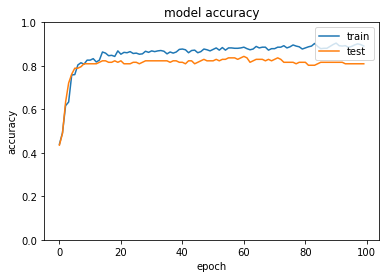

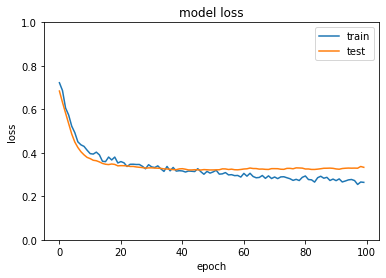

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        85
           1       0.87      0.89      0.88        99

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



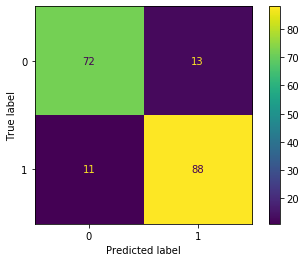

In [41]:
dnn.run_metrics()

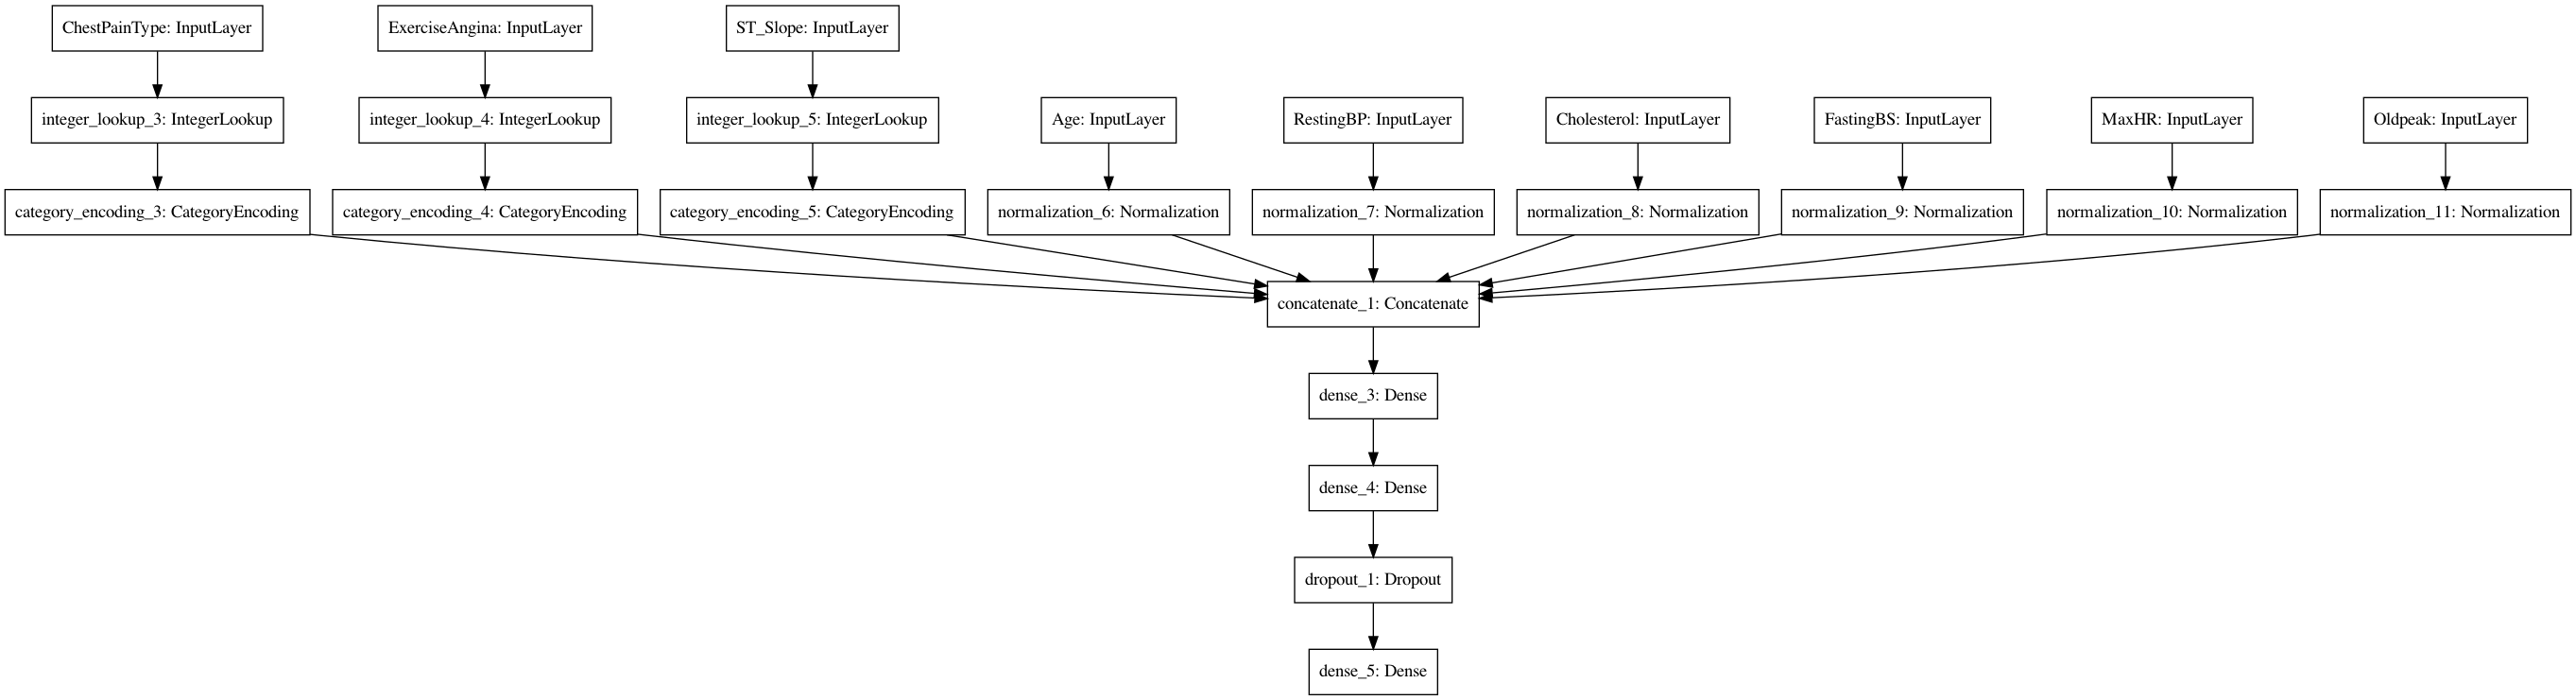

In [42]:
tf.keras.utils.plot_model(dnn.model)

In [3]:
def df_cleanup(data):
    working_data = data.copy()
    index = {}
    for header in working_data:
        if working_data[header].dtype == 'O':
            unique_values_in_column = list(working_data[header].unique())
            column_indexer = {k:v for k,v in enumerate(unique_values_in_column)}
            index[header] = column_indexer
            working_data[header] = working_data[header].replace({v:k for k,v in column_indexer.items()})
    
    return working_data, index

In [ ]:
from collections import Counter
import math
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing as pp


In [4]:
working_data , index = df_cleanup(df)

In [5]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = [i for i in working_data.columns if i not in categorical_cols]

In [6]:
label = working_data.pop('HeartDisease')

In [7]:
from collections import Counter
import math
import scipy.stats as ss

def conditional_entropy(x,y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurances = sum(y_counter.values())
    entropy = 0.
    for xy in xy_counter.keys():
        p_y = y_counter[xy[1]]/total_occurances
        p_xy = xy_counter[xy]/total_occurances
        entropy += p_xy * math.log(p_y/ p_xy, math.e)
    return entropy

def theils_u(x,y):
    # coeff = (H(X) - H(X|Y)) / H(X) 
    h_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurances = sum(x_counter.values())
    p_x = list(map(lambda x: x / total_occurances, x_counter.values()))
    h_x = ss.entropy(p_x)
    if h_x == 0:
        return 1
    else: 
        return (h_x - h_xy)/h_x



In [9]:
def calculate_entropy_for_dataframe(df, label, header = None):
    if header == None:
        header = df.columns
    d = {}
    for h in header:
        d[h] = theils_u(df[h], label)
    return d

def numerical_corr(x,y):
    r = ss.pointbiserialr(x, y).correlation
    return r

def calculate_entropy_for_dataframe_numerical_data(df, label, header = None):
    if header == None:
        header = df.columns
    d = {}
    for h in header:
        d[h] = numerical_corr(df[h], label)
    return d

In [10]:
correlation_data = {}
filtered_categorical_cols = calculate_entropy_for_dataframe(working_data, 
                                                        label, 
                                                        header=categorical_cols)

In [12]:
filtered_numerical_cols = calculate_entropy_for_dataframe_numerical_data(working_data,label,header=numerical_cols[:-1])
filtered_cat_cols = [k for k,v in filtered_categorical_cols.items() if abs(v)>0.1]
filtered_num_cols = [k for k,v in filtered_numerical_cols.items() if abs(v)>0.1]
sifnificant_cols = filtered_num_cols+filtered_cat_cols

# OLD MODEL

def preprocess_categorical(dataframe):
    df = dataframe.copy()
    cols = df.columns
    for col in cols:
        categorical_dict = {}
        if df[col].dtype == 'object':
            unique_values = {v:k for k,v in zip(range(len(df[col].unique())), df[col].unique())}
            categorical_dict[col] = unique_values
            print(unique_values)
            df[col] = df[col].apply(lambda x: unique_values[x])
    return df

processed_df = preprocess_categorical(df)

import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(processed_df, 
                         test_size = 0.1,
                         stratify=processed_df.HeartDisease)

X_train_label = X_train.HeartDisease
X_train = X_train[[i for i in X_train if i!='HeartDisease']]


X_train = X_train.to_numpy()
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))

from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, MaxPooling1D, Conv1D
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=64, input_shape=(1, 11), return_sequences=True))
# model.add(LSTM(units=64, input_shape=(1, 5), return_sequences=True))

model.add(Activation('relu'))

model.add(LSTM(units=128, return_sequences=True))
model.add(Activation('relu'))

model.add(LSTM(units=256, return_sequences=True))
model.add(Activation('relu'))

model.add(LSTM(units=512, return_sequences=True))
model.add(Activation('relu'))

model.add(Conv1D(filters=1024, kernel_size=(1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(1)))

model.add(Conv1D(filters=2048, kernel_size=(1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(1)))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer="Adamax", loss="binary_crossentropy", metrics=["accuracy"])

import tensorflow as tf
cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

hst = model.fit(tf.cast(X_train, tf.float32), 
                tf.cast(X_train_label, tf.int8),
                validation_split=0.1, 
                epochs =25,
                batch_size=16, 
                shuffle=True,
                callbacks=cb)

X_test_label = X_test.HeartDisease
X_test = X_test[[i for i in X_test if i!='HeartDisease']]
X_test = X_test.to_numpy()
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
model.evaluate(tf.cast(X_test, tf.float32), 
                tf.cast(X_test_label, tf.int8))

predicted = []
for i in range(df.shape[0]):
    p = model.predict(np.reshape(np.array(processed_df.loc[i][:-1]), (1,1,11)))[0][0][0]
    predicted.append(p)
    
df['predicted'] = [*map(round ,predicted)]
series = df.apply(lambda x: x['HeartDisease']==x['predicted'] , axis=1)
series.value_counts().plot(kind='bar')

# round3
epochs = len(hst.epoch)
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

# New Model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [16]:
import tensorflow as tf

# Model creation

In [18]:
def dataset_from_dataframe(df, label, batch_size=32):
    data = df.copy()
    data = tf.data.Dataset.from_tensor_slices((dict(df), label))
    data = data.batch(batch_size)
    data = data.prefetch(batch_size)
    return data
def get_categorical_encoding_layer(feature, dataset, dtype, max_tokens):
    index = pp.IntegerLookup(max_values=max_tokens, oov_value=-2) # integer lookup initialization 
    feature_ds = dataset.map(lambda x, y: x[feature]) # slice dataset to get the feature column
    index.adapt(feature_ds) # analyze the feature column to generate a vocabulary 
    encoder = pp.CategoryEncoding(max_tokens=len(index.get_vocabulary())) # generate an encoding layer 
    return lambda feature: encoder(index(feature)) #returns a encoder which takes feature as argument

def get_normalization_layer(feature, dataset):
    normalizer = pp.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[feature])
    normalizer.adapt(feature_ds)
    return normalizer

In [20]:
ds = working_data[sifnificant_cols]
batch_size = 32

train, test, train_label, test_label = train_test_split(ds, label, test_size=0.2)
train, val, train_label, val_label = train_test_split(train, train_label, test_size=0.2)

train_ds = dataset_from_dataframe(train, train_label)
val_ds = dataset_from_dataframe(val, val_label)
test_ds = dataset_from_dataframe(test, test_label)

all_inputs = []
encoded_inputs = []

for header in filtered_cat_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
    encoding_layer = get_categorical_encoding_layer(feature=header, 
                                              dataset=train_ds,
                                              dtype='int32',
                                              max_tokens=5 #random_number do optimize
                                             )
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_inputs.append(encoded_categorical_col)
    
for header in filtered_num_cols:
    numerical_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(feature=header, 
                                                  dataset=train_ds
                                                 )
    normalized_numerical_layer = normalization_layer(numerical_col)
    all_inputs.append(numerical_col)
    encoded_inputs.append(normalized_numerical_layer)
    
all_features = tf.keras.layers.concatenate(encoded_inputs)

x = tf.keras.layers.Dense(20, activation="relu")(all_features)
x = tf.keras.layers.Dense(30, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing as pp


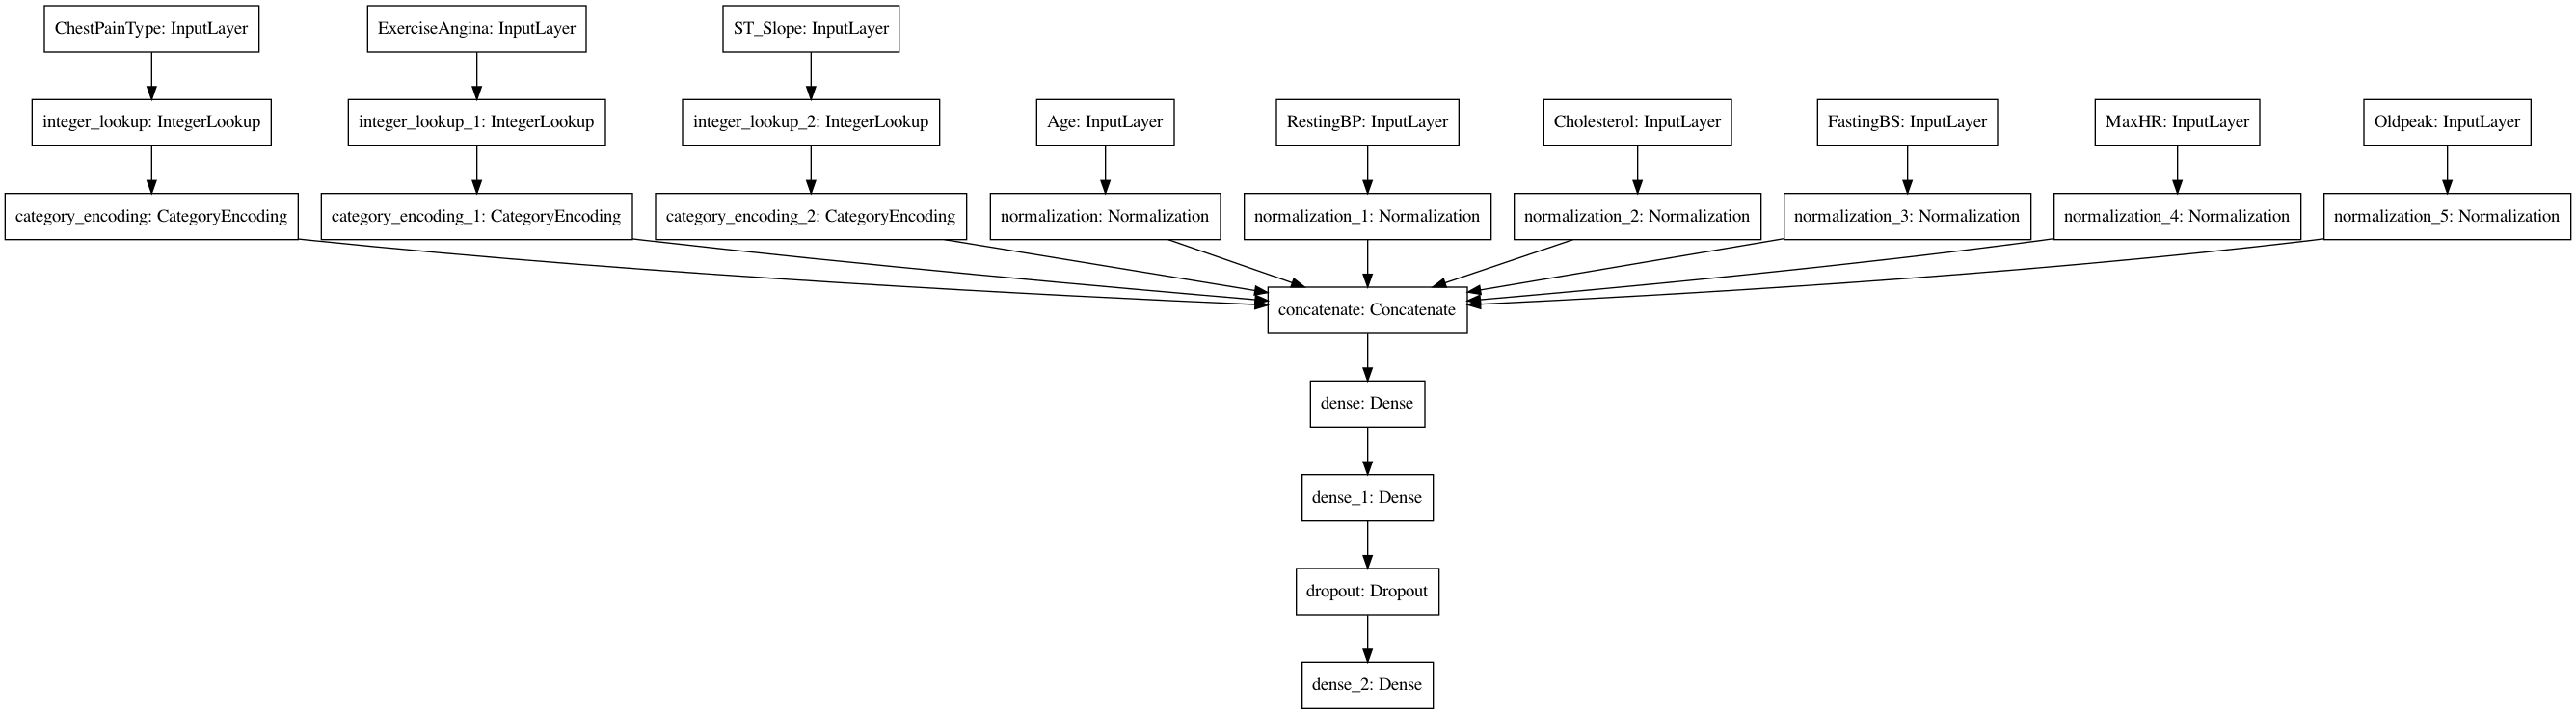

In [26]:
tf.keras.utils.plot_model(model)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ChestPainType (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
ExerciseAngina (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
ST_Slope (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           ChestPainType[0][0]              
______________________________________________________________________________________________

In [28]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=100,
                    verbose=True)

Epoch 1/100
19/19 [==============================] - 2s 60ms/step - loss: 0.6604 - accuracy: 0.5055 - val_loss: 0.6174 - val_accuracy: 0.4762
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.5747 - val_loss: 0.5700 - val_accuracy: 0.5374
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5666 - accuracy: 0.6004 - val_loss: 0.5296 - val_accuracy: 0.6463
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.5206 - accuracy: 0.6939 - val_loss: 0.4962 - val_accuracy: 0.7619
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.7462 - val_loss: 0.4695 - val_accuracy: 0.7891
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.7796 - val_loss: 0.4486 - val_accuracy: 0.7891
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.7771 - val_loss: 0.4358 - val_accuracy: 0.7891
Epoch 8/100


Epoch 59/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3072 - accuracy: 0.8785 - val_loss: 0.3623 - val_accuracy: 0.8435
Epoch 60/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3012 - accuracy: 0.8849 - val_loss: 0.3612 - val_accuracy: 0.8435
Epoch 61/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3067 - accuracy: 0.8712 - val_loss: 0.3606 - val_accuracy: 0.8435
Epoch 62/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3160 - accuracy: 0.8836 - val_loss: 0.3605 - val_accuracy: 0.8435
Epoch 63/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.8824 - val_loss: 0.3605 - val_accuracy: 0.8435
Epoch 64/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3159 - accuracy: 0.8952 - val_loss: 0.3605 - val_accuracy: 0.8435
Epoch 65/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2932 - accuracy: 0.8938 - val_loss: 0.3629 - val_accuracy: 0.8435
Epoch 

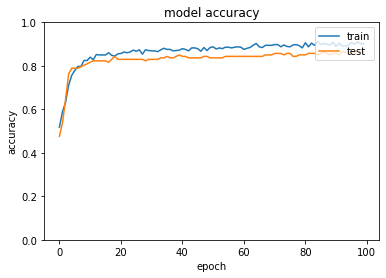

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,1)
plt.show()


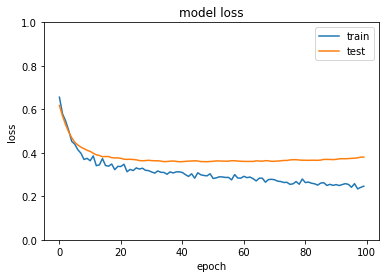

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,1)
plt.show()

In [31]:
predictions = model.predict(test_ds)

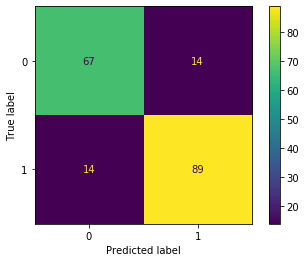

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

binary_prediction = [1 if i>0.5 else 0 for i in predictions.reshape(-1)]
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label, binary_prediction)).plot()

In [33]:
binary_prediction = [1 if i>0.5 else 0 for i in predictions.reshape(-1)]
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label, binary_prediction)).plot()
print(classification_report(test_label, binary_prediction))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        81
           1       0.86      0.86      0.86       103

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



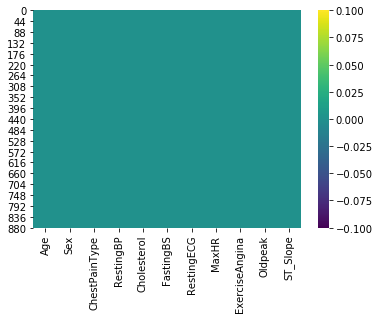